# LoFi v.s. subspaceEKF

In [292]:
import jax
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Callable
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter.subspace_filter import subcify
from rebayes.low_rank_filter import lofi
from rebayes.datasets.datasets import load_mnist

In [28]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
res = load_mnist()
res = jax.tree_map(jnp.array, res)
(X_train, y_train), (X_test, y_test) = res
X_train = einops.rearrange(X_train, "obs width height -> obs (width height)")
X_test = einops.rearrange(X_test, "obs width height -> obs (width height)")

y_train_ohe = jax.nn.one_hot(y_train, 10)
y_test_ohe = jax.nn.one_hot(y_test, 10)

In [295]:
class NNet(nn.Module):
    activation: Callable = nn.elu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(300)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = nn.softmax(x)
        return x

In [296]:
key = jax.random.PRNGKey(314)
model = NNet()
params_init = model.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

## LoFi agent

In [297]:
def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):    
    # eval on all tasks test set
    yhat = agent.emission_mean_function(bel.mean, X_test).argmax(axis=1)
    acc = jnp.mean(yhat == y_test)
    
    out = {
        "acc": acc
    }
    
    return out

In [307]:
agent, recfn = lofi.init_classification_agent(
    model,
    X_train[:10],
    dynamics_weights=1.0,
    dynamics_covariance=1e-7,
    memory_size=20,
)

In [308]:
%%time
bel, outputs = agent.scan(
    initial_mean=params_init_flat,
    initial_covariance=1e-7,
    X=X_train[:5000],
    Y=y_train[:5000],
    progress_bar=False,
    callback=callback,
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)

CPU times: user 1min 10s, sys: 961 ms, total: 1min 11s
Wall time: 1min 19s


In [309]:
outputs["acc"]

array([0.08419999, 0.08419999, 0.08419999, ..., 0.1511    , 0.151     ,
       0.1511    ], dtype=float32)

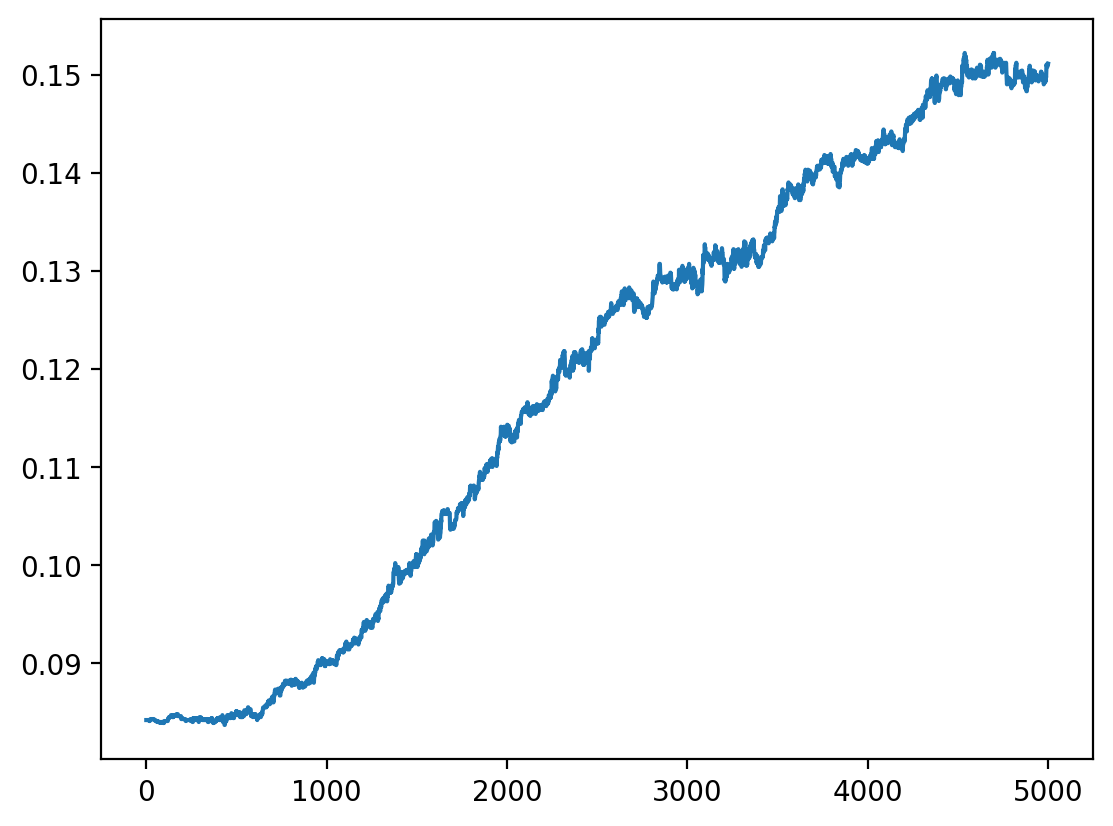

In [311]:
plt.plot(outputs["acc"])
plt.grid(alpha=0.3)

In [312]:
yhat_test = agent.predict_obs(bel, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

Array(0.1511, dtype=float32)

## Subspace agent

In [393]:
SubNNet = subcify(NNet)
dim_in = 28 ** 2

model_sub = SubNNet(dim_in, dim_subspace=20)

params_init = model_sub.init(key, X_train[:10])
params_init_flat, _ = ravel_pytree(params_init)

In [394]:
pfixed, psubspace_init = params_init["fixed"], params_init["params"]
psubspace_init_flat, recfn = ravel_pytree(psubspace_init)

In [395]:
def applyfn(psubspace, X):
    pfull = {
        "fixed": pfixed,
        "params": psubspace
    }
    return model_sub.apply(pfull, X)

In [398]:
dynamics_weights=1.0
dynamics_covariance=1e-5
method="fcekf"

In [399]:
def apply_fn(flat_params, x):
    return applyfn(recfn(flat_params), x)

def emission_cov_fn(flat_params, x, eps=1e-7):
    p = apply_fn(flat_params, x).ravel()
    return eps * jnp.eye(len(p)) + jnp.diag(p) - jnp.outer(p, p)

agent = ekf.RebayesEKF(
    dynamics_weights_or_function=dynamics_weights,
    dynamics_covariance=dynamics_covariance,
    emission_mean_function=apply_fn,
    emission_cov_function=emission_cov_fn,
    adaptive_emission_cov=False,
    emission_dist=lambda mean, cov: tfd.Normal(loc=mean, scale=jnp.sqrt(cov)),
    method=method,
)

In [400]:
%%time
bel, outputs = agent.scan(
    initial_mean=psubspace_init_flat,
    initial_covariance=1e-7,
    X=X_train[:5000],
    Y=y_train[:5000],
    progress_bar=False,
    callback=callback
)

bel = jax.block_until_ready(bel)
outputs = jax.tree_map(np.array, outputs)

CPU times: user 36.4 s, sys: 390 ms, total: 36.8 s
Wall time: 42.3 s


In [401]:
yhat_test = apply_fn(bel.mean, X_test).argmax(axis=1)
(yhat_test == y_test).mean()

Array(0.1032, dtype=float32)

In [402]:
outputs["acc"]

array([0.1032, 0.1032, 0.1032, ..., 0.1032, 0.1032, 0.1032], dtype=float32)

In [404]:
psubspace_init_flat

Array([ 0.00696627,  0.00554405, -0.02024065, -0.00067848,  0.00410194,
       -0.01721293,  0.00460709,  0.00021611, -0.00058186,  0.01055648,
        0.00691188,  0.00215736, -0.00032204, -0.02113763,  0.01399151,
        0.01192655,  0.00699835,  0.00467775, -0.0083865 ,  0.01283646],      dtype=float32)

In [405]:
bel.mean

Array([ 1.0815313e-02,  6.8329303e-03, -1.7106773e-02,  9.1323303e-03,
       -4.6156188e-03, -2.7523503e-02,  7.9042511e-03, -5.8795749e-03,
       -5.3365168e-04,  1.3293023e-03,  2.7419038e-03,  4.7352663e-03,
        2.6973924e-03, -2.5136486e-02,  8.8624042e-03,  1.0435204e-02,
       -5.8796475e-05, -3.6652931e-03, -5.6370050e-03,  6.8868888e-03],      dtype=float32)